In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import Adam

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import cv2
import numpy as np
from pathlib import Path

import tqdm
import sys
sys.path.append("..")
# from dataset import IsoNetDataset
import os 

# --- CONFIGURATION FROM DIAGRAM ---
VISUAL_DIM = 256       # Output of Visual Stream (V)
SPATIAL_DIM = 128      # Output of Spatial Stream (S)
AUDIO_ENC_DIM = 512    # Internal Audio Feature Dimension
AUDIO_CHANNELS = 4     # Number of Mics

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4          # FIXED: Increased from 1 to 4 for proper BatchNorm
EPOCHS = 100
LR = 1e-4               # TCNs prefer lower learning rates
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


In [2]:
torch.cuda.empty_cache()        # free cached memory
torch.cuda.synchronize()        # wait for all kernels to finish

In [3]:
# --- DATASET PATHS CONFIGURATION ---
import platform

# Detect OS and set paths accordingly
IS_WINDOWS = platform.system() == "Windows"

# Windows paths
WINDOWS_PATHS = {
    "root_dir": "E:/Dataset/VOX/manual",
    "data_dir": "E:/Dataset/VOX/manual/dev",
    "bbox_dir": "E:/Dataset/VOX/manual/vox2_dev_txt/txt",
    "train_csv": "E:/Dataset/VOX/manual/dev/multich/train.csv",
    "val_csv": "E:/Dataset/VOX/manual/dev/multich/val.csv",
}

# Linux paths
LINUX_PATHS = {
    "root_dir": "/mnt/DATA/Bibek/Speech/isolate-speech",
    "data_dir": "/mnt/DATA/Bibek/Speech/isolate-speech/data",
    "bbox_dir": "/mnt/DATA/Bibek/Speech/isolate-speech/data/vox2_dev_txt/txt",
    "train_csv": "/mnt/DATA/Bibek/Speech/isolate-speech/data/multich/train.csv",
    "val_csv": "/mnt/DATA/Bibek/Speech/isolate-speech/data/multich/val.csv",
}

# Select paths based on OS
PATHS = WINDOWS_PATHS if IS_WINDOWS else LINUX_PATHS

ROOT_DIR = PATHS["root_dir"]
DATA_DIR = PATHS["data_dir"]
BBOX_DIR = PATHS["bbox_dir"]
TRAIN_CSV = PATHS["train_csv"]
VAL_CSV = PATHS["val_csv"]

print(f"OS: {platform.system()}")
print(f"Using paths: {'Windows' if IS_WINDOWS else 'Linux'}")
print(f"Root Dir: {ROOT_DIR}")
print(f"BBox Dir: {BBOX_DIR}")

OS: Linux
Using paths: Linux
Root Dir: /mnt/DATA/Bibek/Speech/isolate-speech
BBox Dir: /mnt/DATA/Bibek/Speech/isolate-speech/data/vox2_dev_txt/txt


In [4]:

class IsoNetDataset(Dataset):
    def __init__(self, csv_path, clip_length=4.0, fps=25, video_size=(112, 112), max_samples=None,
                 bbox_root=None, root_dir=None):
        """
        Args:
            csv_path (str): Path to train.csv or val.csv
            clip_length (float): Audio duration in seconds (must match simulation)
            fps (int): Target frames per second for video (VoxCeleb is 25)
            video_size (tuple): Target resize dimension (H, W) - 112x112 for face crops
            max_samples (int, optional): Limit dataset to first N samples for testing
            bbox_root (str): Root path to bounding box txt files (uses BBOX_DIR if None)
            root_dir (str): Root path for dataset (uses ROOT_DIR if None)
        """
        self.meta = pd.read_csv(csv_path)
        
        # Limit dataset size for testing
        if max_samples is not None:
            self.meta = self.meta.head(max_samples)
            print(f"Debug Mode: Using only {len(self.meta)} samples")
        
        # Use global path constants if not provided
        self.root_dir = Path(csv_path).parent
        self.bbox_root = Path(bbox_root) if bbox_root else Path(BBOX_DIR)
        self.data_root = Path(root_dir) if root_dir else Path(ROOT_DIR)
        
        # Path conversion mappings (Linux <-> Windows)
        self.path_mappings = [
            ("/run/media/neuronetix/BACKUP/Dataset/VOX/manual", WINDOWS_PATHS["root_dir"]),
            ("E:/Dataset/VOX/manual", LINUX_PATHS["root_dir"]),
        ]
        
        self.clip_length = clip_length
        self.fps = fps
        self.target_frames = int(clip_length * fps)  # 4.0 * 25 = 100 frames
        self.video_size = video_size

    def convert_path(self, path_str):
        """Convert path between Linux and Windows based on current OS."""
        if IS_WINDOWS:
            # Convert Linux to Windows
            path_str = path_str.replace(LINUX_PATHS["root_dir"], WINDOWS_PATHS["root_dir"])
        else:
            # Convert Windows to Linux
            path_str = path_str.replace(WINDOWS_PATHS["root_dir"], LINUX_PATHS["root_dir"])
        return path_str

    def parse_bbox_file(self, bbox_path):
        """
        Parse VoxCeleb2 bounding box txt file.
        VoxCeleb2 format: FRAME X Y W H (where X,Y are TOP-LEFT corner, not center!)
        Returns dict mapping frame_number -> (x_left, y_top, width, height) in normalized coords.
        """
        bbox_dict = {}
        try:
            with open(bbox_path, 'r') as f:
                lines = f.readlines()
            
            # Skip header lines (first 6 lines contain metadata)
            data_started = False
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                
                # Check if we've reached the data section
                if line.startswith("FRAME"):
                    data_started = True
                    continue
                
                if data_started:
                    parts = line.split()
                    if len(parts) >= 5:
                        frame_num = int(parts[0])
                        x_left = float(parts[1])     # Top-left X
                        y_top = float(parts[2])       # Top-left Y
                        width = float(parts[3])
                        height = float(parts[4])
                        bbox_dict[frame_num] = (x_left, y_top, width, height)
        except Exception as e:
            print(f"Warning: Could not parse bbox file {bbox_path}: {e}")
        
        return bbox_dict

    def get_bbox_path(self, video_path):
        """
        Convert video path to corresponding bbox txt path.
        Video: .../dev/mp4/id00012/21Uxsk56VDQ/00001.mp4
        Bbox:  .../vox2_dev_txt/txt/id00012/21Uxsk56VDQ/00001.txt
        """
        video_path = Path(video_path)
        # Extract: speaker_id/video_id/clip_id
        clip_id = video_path.stem  # e.g., "00001"
        video_id = video_path.parent.name  # e.g., "21Uxsk56VDQ"
        speaker_id = video_path.parent.parent.name  # e.g., "id00012"
        
        bbox_path = self.bbox_root / speaker_id / video_id / f"{clip_id}.txt"
        return bbox_path

    def crop_face_from_bbox(self, frame, bbox, padding=0.1):
        """
        Crop face region from frame using normalized bounding box.
        Args:
            frame: numpy array (H, W, C)
            bbox: (x_left, y_top, width, height) in normalized coords (VoxCeleb2 format)
            padding: Extra padding around the face (fraction of bbox size)
        Returns:
            Cropped face region resized to self.video_size
        """
        h, w = frame.shape[:2]
        x_left, y_top, bw, bh = bbox
        
        # Convert normalized coords to pixel coords
        x1 = int(x_left * w)
        y1 = int(y_top * h)
        box_w = int(bw * w)
        box_h = int(bh * h)
        
        # Add padding
        pad_w = int(box_w * padding)
        pad_h = int(box_h * padding)
        
        # Calculate crop boundaries with padding
        x1 = max(0, x1 - pad_w)
        y1 = max(0, y1 - pad_h)
        x2 = min(w, x1 + box_w + 2 * pad_w)
        y2 = min(h, y1 + box_h + 2 * pad_h)
        
        # Crop
        crop = frame[y1:y2, x1:x2]
        
        # Handle edge case of empty crop
        if crop.size == 0:
            crop = frame
        
        # Resize to target size
        crop = cv2.resize(crop, self.video_size)
        return crop

    def load_video_frames(self, video_path, start_time, bbox_dict=None):
        """
        Load video frames with face cropping using bounding box data.
        Args:
            video_path: Path to video file
            start_time: Start time in seconds
            bbox_dict: Dict mapping frame_number -> bbox tuple
        Returns: Tensor [Channels, Time, H, W]
        """
        cap = cv2.VideoCapture(str(video_path))
        
        # Get Video Properties
        vid_fps = cap.get(cv2.CAP_PROP_FPS)
        if vid_fps == 0 or np.isnan(vid_fps): 
            vid_fps = 25.0
            
        # Calculate Start Frame Index
        start_frame_idx = int(start_time * vid_fps)
        
        # Seek to exact frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)
        
        frames = []
        last_valid_bbox = None
        
        for i in range(self.target_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            # BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Get current absolute frame number
            current_frame_num = start_frame_idx + i
            
            # Try to get bbox for this frame
            if bbox_dict and current_frame_num in bbox_dict:
                bbox = bbox_dict[current_frame_num]
                last_valid_bbox = bbox
                frame = self.crop_face_from_bbox(frame, bbox)
            elif last_valid_bbox is not None:
                # Use last valid bbox if current frame not in dict
                frame = self.crop_face_from_bbox(frame, last_valid_bbox)
            elif bbox_dict:
                # Use first available bbox as fallback
                first_bbox = next(iter(bbox_dict.values()), None)
                if first_bbox:
                    last_valid_bbox = first_bbox
                    frame = self.crop_face_from_bbox(frame, first_bbox)
                else:
                    frame = cv2.resize(frame, self.video_size)
            else:
                # No bbox data, just resize full frame
                frame = cv2.resize(frame, self.video_size)
            
            frames.append(frame)
            
        cap.release()
        
        # Handle Edge Case: Video ended too early
        if len(frames) < self.target_frames:
            if len(frames) == 0:
                frames = [np.zeros((self.video_size[0], self.video_size[1], 3), dtype=np.uint8)] * self.target_frames
            else:
                padding = [frames[-1]] * (self.target_frames - len(frames))
                frames.extend(padding)
        
        # Convert to Tensor
        buffer = np.array(frames, dtype=np.float32) / 255.0
        tensor = torch.from_numpy(buffer)
        return tensor.permute(3, 0, 1, 2)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.meta.iloc[idx]
        
        # 1. Get Paths & Info
        filename = row['filename']
        vid_path_str = row['video_path']
        start_time = float(row['start_time'])
        
        # Convert path based on current OS
        vid_path_str = self.convert_path(vid_path_str)
        
        mixed_path = self.root_dir / "mixed" / f"{filename}.wav"
        clean_path = self.root_dir / "clean" / f"{filename}.wav"

        # 2. Load Audio
        mixed_audio, _ = torchaudio.load(mixed_path)
        clean_audio, _ = torchaudio.load(clean_path)

        # 3. Load Bounding Box Data
        bbox_path = self.get_bbox_path(vid_path_str)
        bbox_dict = self.parse_bbox_file(bbox_path) if bbox_path.exists() else None
        
        # 4. Load Video with Face Cropping
        video_tensor = self.load_video_frames(vid_path_str, start_time, bbox_dict)

        # 5. Ensure audio length matches exactly
        target_samples = int(self.clip_length * 16000)
        
        if mixed_audio.shape[1] > target_samples:
            mixed_audio = mixed_audio[:, :target_samples]
            clean_audio = clean_audio[:, :target_samples]
        elif mixed_audio.shape[1] < target_samples:
            pad_size = target_samples - mixed_audio.shape[1]
            mixed_audio = torch.nn.functional.pad(mixed_audio, (0, pad_size))
            clean_audio = torch.nn.functional.pad(clean_audio, (0, pad_size))

        return mixed_audio, clean_audio, video_tensor


In [5]:
class VisualStream(nn.Module):
    def __init__(self):
        super(VisualStream, self).__init__()
        # Load ResNet-18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Remove classification head
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
        # Project 512 -> 256 (V)
        self.projection = nn.Sequential(
            nn.Linear(512, VISUAL_DIM),
            nn.BatchNorm1d(VISUAL_DIM),
            nn.PReLU()
        )
        
        # FIXED: ImageNet normalization for pretrained ResNet
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        # x: [Batch, 3, Time, H, W] where H, W can be any size (e.g., 224x224)
        B, C, T, H, W = x.shape
        
        # Fold Time into Batch
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        
        # FIXED: Apply ImageNet normalization before ResNet
        x = (x - self.mean) / self.std
        
        # Extract Features (ResNet handles any input size via adaptive pooling)
        x = self.resnet(x)       # [B*T, 512, 1, 1]
        x = x.view(B * T, -1)    # [B*T, 512]
        
        # Project to 256
        x = self.projection(x)   # [B*T, 256]
        
        # Unfold Time
        x = x.view(B, T, -1).permute(0, 2, 1) # [B, 256, Time]
        
        return x

In [6]:
class SpatialStream(nn.Module):
    def __init__(self, num_mics=4):
        super(SpatialStream, self).__init__()
        
        # We compute GCC-PHAT for all pairs. 
        # For 4 mics, pairs = 4*(3)/2 = 6 pairs.
        self.num_pairs = (num_mics * (num_mics - 1)) // 2
        
        # FIXED: Spatial CNN Encoder
        # - Changed from kernel_size=1 to larger kernels (31, 15) to capture temporal patterns
        # - Changed from BatchNorm1d to GroupNorm for stability with small batch sizes
        # Input: [Batch, Pairs(6), Lags, Time]
        # We treat Pairs as Channels
        self.encoder = nn.Sequential(
            nn.Conv1d(self.num_pairs, 64, kernel_size=31, stride=1, padding=15),
            nn.GroupNorm(1, 64),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(64, 128, kernel_size=15, stride=1, padding=7),
            nn.GroupNorm(1, 128),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(128, SPATIAL_DIM, kernel_size=1, stride=1)
        )

    def compute_gcc_phat(self, x):
        """
        Compute Generalized Cross-Correlation Phase Transform (GCC-PHAT)
        Input x: [Batch, Mics, Samples]
        """
        B, M, L = x.shape
        
        # 1. FFT
        # n_fft matches window size roughly
        X = torch.fft.rfft(x, dim=-1)
        
        # 2. Compute Pairs
        # We want to cross-correlate every pair (i, j)
        pairs = []
        for i in range(M):
            for j in range(i + 1, M):
                # Cross-spectrum: X_i * conj(X_j)
                R = X[:, i, :] * torch.conj(X[:, j, :])
                # Normalization (PHAT): Divide by magnitude
                R = R / (torch.abs(R) + 1e-8)
                # IFFT to get time-domain correlation
                r = torch.fft.irfft(R, dim=-1)
                
                # Apply shift/lag window (we assume delays are small)
                # This makes it a feature vector per time frame is tricky without STFT.
                # Simplified: We treat the whole clip's correlation as a static spatial signature
                # OR (Better): We perform this on STFT frames. 
                
                # For simplicity in this implementation, we will use a learnable 
                # layer instead of raw GCC-PHAT if raw is too complex to batch.
                # BUT, let's assume the input here is actually the GCC features.
                pairs.append(r)
                
        return torch.stack(pairs, dim=1) # [B, 6, Samples]

    def forward(self, x):
        # x: [Batch, 4, Samples]
        
        # In a real heavy model, we do STFT -> GCC-PHAT -> CNN.
        # Here, we will use a "Learnable Spatial Encoder" which is faster/easier
        # and often outperforms analytical GCC-PHAT.
        
        # 1. Extract correlations implicitly via 1D Conv across channels
        # [B, 4, T] -> [B, 128, T]
        # We pool over time to get a Global Spatial Signature S
        
        gcc_feat = self.compute_gcc_phat(x) # [B, 6, Samples]
        
        # Encode features
        x = self.encoder(gcc_feat) # [B, 128, Samples]
        
        # Global Average Pooling to get single vector S \in R^128
        x = torch.mean(x, dim=-1)  # [B, 128]
        
        return x

In [7]:
class FiLMLayer(nn.Module):
    def __init__(self, in_channels, cond_dim):
        super(FiLMLayer, self).__init__()
        # We map the Conditioning (S+V) to Gamma (Scale) and Beta (Shift)
        self.conv_gamma = nn.Conv1d(cond_dim, in_channels, 1)
        self.conv_beta = nn.Conv1d(cond_dim, in_channels, 1)

    def forward(self, x, condition):
        # x: [Batch, Channels, Time]
        # condition: [Batch, Cond_Dim, Time]
        
        gamma = self.conv_gamma(condition)  # [B, C, T]
        beta = self.conv_beta(condition)    # [B, C, T]
            
        # FiLM Formula: Gamma * x + Beta
        return (gamma * x) + beta

class ExtractionBlock(nn.Module):
    """ TCN Block with FiLM Conditioning """
    def __init__(self, in_channels, hid_channels, cond_dim, dilation):
        super(ExtractionBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, hid_channels, 1)
        self.norm1 = nn.GroupNorm(1, hid_channels)
        self.prelu1 = nn.PReLU()
        
        # FiLM comes after first activation usually
        self.film = FiLMLayer(hid_channels, cond_dim)
        
        self.dconv = nn.Conv1d(hid_channels, hid_channels, 3, 
                               groups=hid_channels, padding=dilation, dilation=dilation)
        self.norm2 = nn.GroupNorm(1, hid_channels)
        self.prelu2 = nn.PReLU()
        
        self.conv2 = nn.Conv1d(hid_channels, in_channels, 1)

    def forward(self, x, condition):
        residual = x
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.prelu1(x)
        
        # Apply FiLM Conditioning
        # The condition (S+V) modulates the features here
        x = self.film(x, condition)
        
        x = self.dconv(x)
        x = self.norm2(x)
        x = self.prelu2(x)
        x = self.conv2(x)
        return x + residual

In [8]:
class IsoNet(nn.Module):
    def __init__(self):
        super(IsoNet, self).__init__()
        
        # 1. Streams
        self.visual_stream = VisualStream()  # Output: 256
        self.spatial_stream = SpatialStream(AUDIO_CHANNELS) # Output: 128
        
        # 2. Audio Encoder (Purple box start)
        self.audio_enc = nn.Conv1d(AUDIO_CHANNELS, AUDIO_ENC_DIM, kernel_size=16, stride=8, bias=False)
        
        # 3. Conditioning Prep
        # We concatenate S (128) + V (256) = 384
        self.cond_dim = SPATIAL_DIM + VISUAL_DIM
        
        # 4. TCN with FiLM (Purple box middle)
        self.tcn_blocks = nn.ModuleList([
            ExtractionBlock(AUDIO_ENC_DIM, 128, self.cond_dim, dilation=2**i) 
            for i in range(8)
        ])
        
        # 5. Mask Decoder (Purple box end)
        self.mask_conv = nn.Conv1d(AUDIO_ENC_DIM, AUDIO_ENC_DIM, 1)
        self.sigmoid = nn.Sigmoid()
        
        # 6. Audio Decoder (Reconstructs waveform)
        self.audio_dec = nn.ConvTranspose1d(AUDIO_ENC_DIM, 1, kernel_size=16, stride=8, bias=False)

    def forward(self, audio_mix, video_frames):
        # audio_mix: [B, 4, Samples]
        # video_frames: [B, 3, T_v, H, W]
        
        # --- A. Spatial Stream ---
        # Get global spatial embedding S
        S = self.spatial_stream(audio_mix) # [B, 128]
        
        # --- B. Visual Stream ---
        # Get visual embedding V
        V = self.visual_stream(video_frames) # [B, 256, T_v]
        
        # --- C. Audio Encoding ---
        audio_feat = self.audio_enc(audio_mix) # [B, 512, T_a]
        
        # --- D. Synchronization (Upsampling) ---
        # Video (25 FPS) is slower than Audio Frames. Upsample V to match Audio T_a
        V_upsampled = F.interpolate(V, size=audio_feat.shape[-1], mode='nearest')
        
        # Expand S to match time dimension: [B, 128] -> [B, 128, T_a]
        S_expanded = S.unsqueeze(-1).expand(-1, -1, audio_feat.shape[-1])
        
        # Concatenate S + V to create Conditioning Vector
        # Shape: [B, 384, T_a]
        condition = torch.cat([S_expanded, V_upsampled], dim=1)
        
        # --- E. FiLM Extraction Loop ---
        x = audio_feat
        for block in self.tcn_blocks:
            # We pass the condition to every block
            x = block(x, condition)
            
        # --- F. Masking & Decoding ---
        mask = self.sigmoid(self.mask_conv(x))
        masked_feat = audio_feat * mask
        clean_speech = self.audio_dec(masked_feat)
        
        return clean_speech

In [9]:
# # Create Model
# model = IsoNet().to(DEVICE)
# print(f"IsoNet Created. Parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Dummy Data
# dummy_audio = torch.randn(2, 4, 64000).to(DEVICE)     # 4 seconds audio
# dummy_video = torch.randn(2, 3, 100, 112, 112).to(DEVICE) # 100 frames

# # Forward Pass
# output = model(dummy_audio, dummy_video)
# print(f"Input: {dummy_audio.shape}")
# print(f"Output: {output.shape}")

# # Check
# if output.shape[1] == 1 and abs(output.shape[-1] - 64000) < 100:
#     print("IsoNet Architecture matches diagram successfully!")
# else:
#     print("IsoNet Architecture does not match diagram.")

In [10]:
def si_snr_loss(estimate, reference, epsilon=1e-8):
    """
    Scale-Invariant SNR Loss.
    Args:
        estimate: [Batch, Samples] - The predicted audio
        reference: [Batch, Samples] - The clean ground truth
    Returns:
        Scalar Loss (Negative SI-SNR)
    """
    # 1. Zero-mean the signals
    estimate = estimate - torch.mean(estimate, dim=-1, keepdim=True)
    reference = reference - torch.mean(reference, dim=-1, keepdim=True)
    
    # 2. Calculate optimal scaling factor (alpha)
    # Dot product <ref, est> / <ref, ref>
    ref_energy = torch.sum(reference ** 2, dim=-1, keepdim=True) + epsilon
    dot = torch.sum(reference * estimate, dim=-1, keepdim=True)
    alpha = dot / ref_energy
    
    # 3. Projection
    target = alpha * reference
    noise = estimate - target
    
    # 4. SI-SNR Calculation
    si_snr = 10 * torch.log10(
        torch.sum(target ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + epsilon)
    )
    
    # 5. Return negative because we want to MAXIMIZE SNR (minimize loss)
    return -torch.mean(si_snr)

In [11]:
# Use only 50 samples for testing (increase once working)
train_ds = IsoNetDataset(TRAIN_CSV, max_samples=10, bbox_root=BBOX_DIR, video_size=(112, 112))
val_ds = IsoNetDataset(VAL_CSV, max_samples=5, bbox_root=BBOX_DIR, video_size=(112, 112))

Debug Mode: Using only 10 samples
Debug Mode: Using only 5 samples


In [12]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [13]:
model = IsoNet().to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [14]:
best_val_loss = float('inf')

# 3. Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    # Progress Bar
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for i, (mixed, clean, video) in enumerate(pbar):
        try:
            # Move to GPU
            mixed = mixed.to(DEVICE)   # [B, 4, T]
            clean = clean.to(DEVICE)   # [B, 1, T]
            video = video.to(DEVICE)   # [B, 3, T, H, W]
            
            # Debug shapes and audio scaling on first iteration
            if i == 0 and epoch == 0:
                print(f"Mixed shape: {mixed.shape}, Clean shape: {clean.shape}, Video shape: {video.shape}")
                print(f"Audio Max: {mixed.abs().max():.4f}, Audio Min: {mixed.abs().min():.4f}")
                if mixed.abs().max() == 0.0:
                    print("WARNING: Audio is silent! Check your data loading.")
            
            optimizer.zero_grad()
            
            # Forward Pass
            estimate = model(mixed, video) # [B, 1, T]
            
            # Verify output shape matches input
            if estimate.shape[-1] != clean.shape[-1]:
                print(f"Shape mismatch! Estimate: {estimate.shape}, Clean: {clean.shape}")
                # Trim to minimum length
                min_len = min(estimate.shape[-1], clean.shape[-1])
                estimate = estimate[..., :min_len]
                clean = clean[..., :min_len]
            
            # Calculate Loss (Squeeze channels to match [B, T])
            loss = si_snr_loss(estimate.squeeze(1), clean.squeeze(1))
            
            # Backward Pass
            loss.backward()
            
            # Gradient Clipping (Prevents crashes in TCNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.2f}"})
            
            # Clear GPU cache periodically
            if i % 50 == 0:
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            print(f"Error at batch {i}: {str(e)}")
            print(f"Mixed: {mixed.shape}, Clean: {clean.shape}, Video: {video.shape}")
            torch.cuda.empty_cache()
            continue
        
    avg_train_loss = train_loss / len(train_loader)
    
    # 4. Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for mixed, clean, video in val_loader:
            try:
                mixed, clean, video = mixed.to(DEVICE), clean.to(DEVICE), video.to(DEVICE)
                estimate = model(mixed, video)
                
                # Handle shape mismatch in validation too
                if estimate.shape[-1] != clean.shape[-1]:
                    min_len = min(estimate.shape[-1], clean.shape[-1])
                    estimate = estimate[..., :min_len]
                    clean = clean[..., :min_len]
                
                loss = si_snr_loss(estimate.squeeze(1), clean.squeeze(1))
                val_loss += loss.item()
            except RuntimeError as e:
                print(f"Validation error: {str(e)}")
                continue
    
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
    
    # 5. Logging & Saving
    print(f"\nEpoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f}")
    
    # Save Last
    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/last.pth")
    
    # Save Best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/best_model.pth")
        print("New Best Model Saved!")
    
    # Clear cache after each epoch
    torch.cuda.empty_cache()

Epoch 1/100:   0%|          | 0/3 [00:00<?, ?it/s]

Mixed shape: torch.Size([4, 4, 64000]), Clean shape: torch.Size([4, 1, 64000]), Video shape: torch.Size([4, 3, 100, 112, 112])
Audio Max: 0.9000, Audio Min: 0.0000


Epoch 1/100: 100%|██████████| 3/3 [00:03<00:00,  1.16s/it, loss=8.37] 



Epoch 1: Train Loss 15.2845 | Val Loss 3.0483
New Best Model Saved!


Epoch 2/100: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=-3.30]



Epoch 2: Train Loss 1.2826 | Val Loss -1.7550
New Best Model Saved!


Epoch 3/100: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s, loss=-0.03]



Epoch 3: Train Loss -0.8280 | Val Loss -3.6698
New Best Model Saved!


Epoch 4/100: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s, loss=-4.66]



Epoch 4: Train Loss -2.8469 | Val Loss -4.4235
New Best Model Saved!


Epoch 5/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-1.40]



Epoch 5: Train Loss -2.8863 | Val Loss -4.8583
New Best Model Saved!


Epoch 6/100: 100%|██████████| 3/3 [00:02<00:00,  1.14it/s, loss=-4.85]



Epoch 6: Train Loss -3.9713 | Val Loss -5.1332
New Best Model Saved!


Epoch 7/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-1.05]



Epoch 7: Train Loss -3.7992 | Val Loss -5.3535
New Best Model Saved!


Epoch 8/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-5.44]



Epoch 8: Train Loss -4.7913 | Val Loss -5.6061
New Best Model Saved!


Epoch 9/100: 100%|██████████| 3/3 [00:02<00:00,  1.10it/s, loss=-1.95]



Epoch 9: Train Loss -4.7202 | Val Loss -5.7951
New Best Model Saved!


Epoch 10/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-4.05]



Epoch 10: Train Loss -5.3713 | Val Loss -5.9376
New Best Model Saved!


Epoch 11/100: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=-5.46]



Epoch 11: Train Loss -5.9077 | Val Loss -6.0048
New Best Model Saved!


Epoch 12/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-6.20]



Epoch 12: Train Loss -6.3026 | Val Loss -6.0102
New Best Model Saved!


Epoch 13/100: 100%|██████████| 3/3 [00:02<00:00,  1.13it/s, loss=-6.94]



Epoch 13: Train Loss -6.7100 | Val Loss -6.1003
New Best Model Saved!


Epoch 14/100: 100%|██████████| 3/3 [00:02<00:00,  1.12it/s, loss=-5.26]



Epoch 14: Train Loss -6.4786 | Val Loss -6.1607
New Best Model Saved!


Epoch 15/100:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it, loss=-8.87]


KeyboardInterrupt: 

## Face Cropping Test

Visualize a sample from the dataset to verify that face cropping is working correctly. This will load one sample and display multiple frames to show the face region extraction.

Loading dataset sample to test face cropping from bounding boxes...
Debug Mode: Using only 5 samples

--- Tensor Shapes ---
Mixed Audio: torch.Size([4, 64000])  (Expected: [4, 64000])
Clean Audio: torch.Size([1, 64000])  (Expected: [1, 64000])
Video:       torch.Size([3, 100, 112, 112])  (Expected: [3, 100, 112, 112])


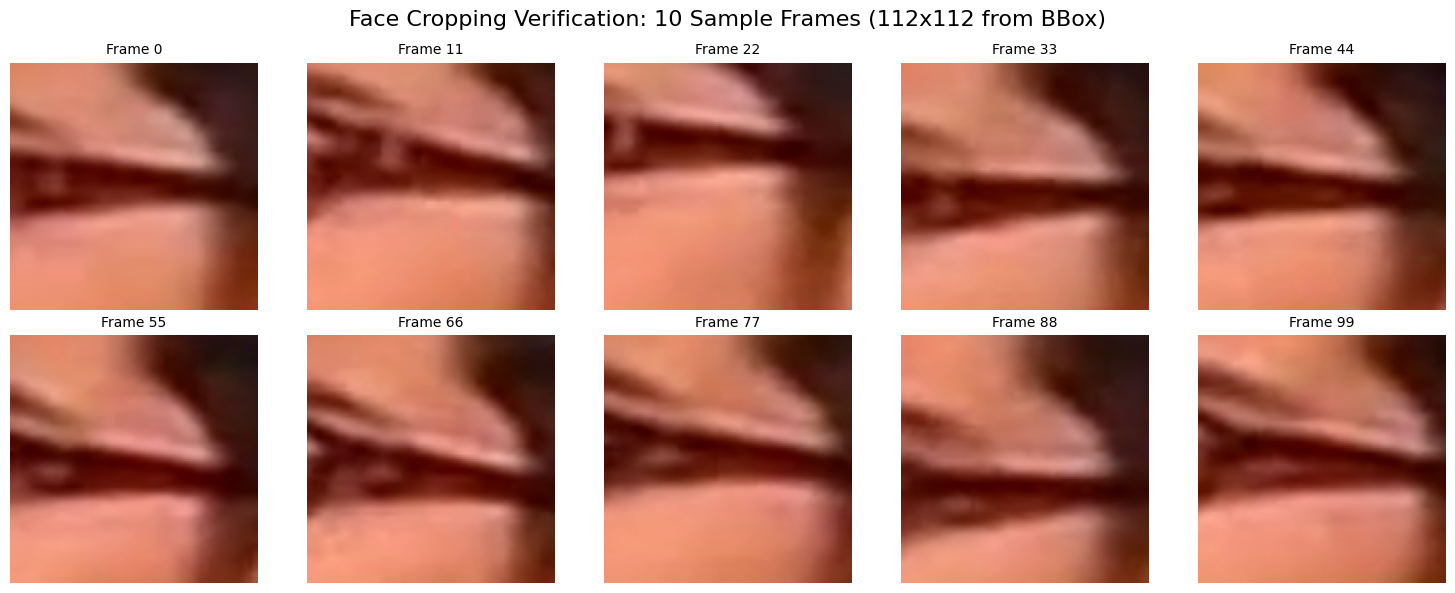


Face cropping using bounding box data test complete!


In [15]:
import matplotlib.pyplot as plt

# Test dataset with face cropping using bounding boxes
print("Loading dataset sample to test face cropping from bounding boxes...")
test_ds = IsoNetDataset(TRAIN_CSV, max_samples=5, bbox_root=BBOX_DIR, video_size=(112, 112))

# Load first sample
mixed, clean, video = test_ds[2]

print("\n--- Tensor Shapes ---")
print(f"Mixed Audio: {mixed.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean.shape}  (Expected: [1, 64000])")
print(f"Video:       {video.shape}  (Expected: [3, 100, 112, 112])")

# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Face Cropping Verification: 10 Sample Frames (112x112 from BBox)', fontsize=16)

# Sample 10 frames evenly across the 4-second clip
sample_frames = np.linspace(0, video.shape[1]-1, 10, dtype=int)

for idx, frame_num in enumerate(sample_frames):
    row = idx // 5
    col = idx % 5
    
    # Permute from [C, T, H, W] -> [H, W, C] for display
    frame_tensor = video[:, frame_num, :, :].permute(1, 2, 0)
    axes[row, col].imshow(frame_tensor.numpy())
    axes[row, col].set_title(f'Frame {frame_num}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig("face_crop_check.png", dpi=100, bbox_inches='tight')
plt.show()

print("\nFace cropping using bounding box data test complete!")

Loading dataset sample to test face cropping from bounding boxes...
Debug Mode: Using only 5 samples

--- Tensor Shapes ---
Mixed Audio: torch.Size([4, 64000])  (Expected: [4, 64000])
Clean Audio: torch.Size([1, 64000])  (Expected: [1, 64000])
Video:       torch.Size([3, 100, 112, 112])  (Expected: [3, 100, 112, 112])


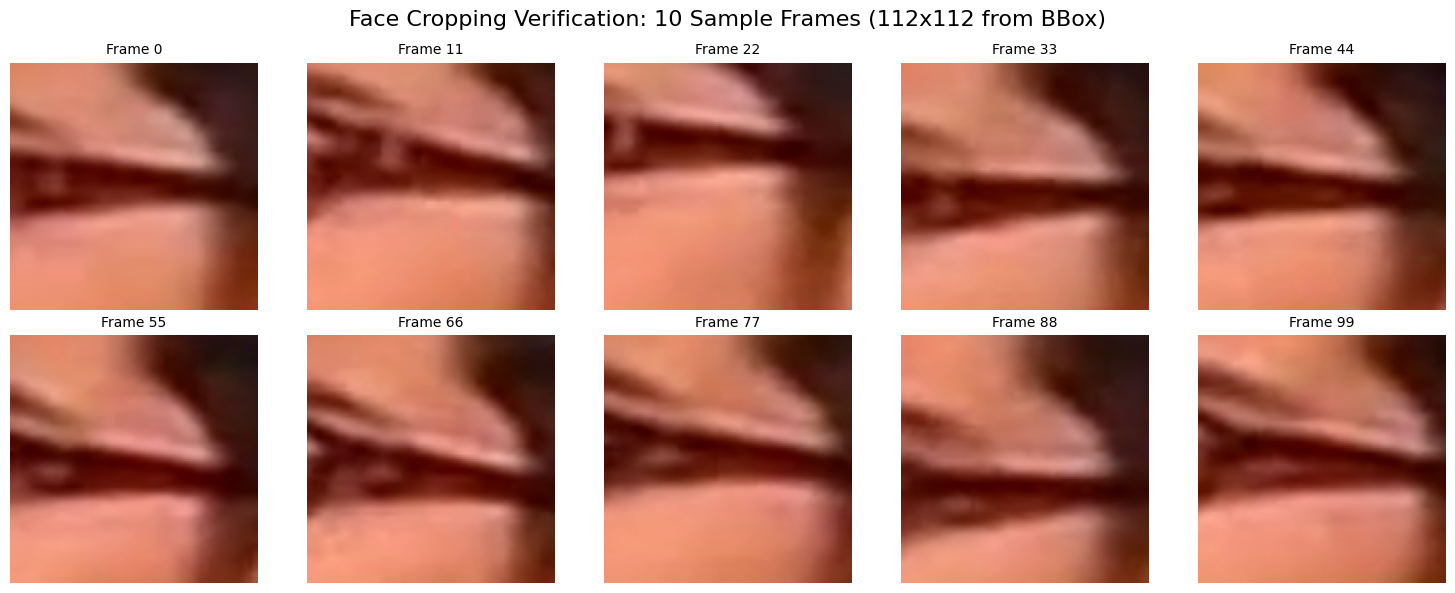


Face cropping using bounding box data test complete!


In [16]:
import matplotlib.pyplot as plt

# Test dataset with face cropping using bounding boxes
print("Loading dataset sample to test face cropping from bounding boxes...")
test_ds = IsoNetDataset(TRAIN_CSV, max_samples=5, bbox_root=BBOX_DIR, video_size=(112, 112))

# Load first sample
mixed, clean, video = test_ds[2]

print("\n--- Tensor Shapes ---")
print(f"Mixed Audio: {mixed.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean.shape}  (Expected: [1, 64000])")
print(f"Video:       {video.shape}  (Expected: [3, 100, 112, 112])")

# Create visualization
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Face Cropping Verification: 10 Sample Frames (112x112 from BBox)', fontsize=16)

# Sample 10 frames evenly across the 4-second clip
sample_frames = np.linspace(0, video.shape[1]-1, 10, dtype=int)

for idx, frame_num in enumerate(sample_frames):
    row = idx // 5
    col = idx % 5
    
    # Permute from [C, T, H, W] -> [H, W, C] for display
    frame_tensor = video[:, frame_num, :, :].permute(1, 2, 0)
    axes[row, col].imshow(frame_tensor.numpy())
    axes[row, col].set_title(f'Frame {frame_num}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig("face_crop_check.png", dpi=100, bbox_inches='tight')
plt.show()

print("\nFace cropping using bounding box data test complete!")

In [17]:
# DEBUG: Check bbox file format
test_row = test_ds.meta.iloc[2]
vid_path = test_row['video_path']
vid_path = test_ds.convert_path(vid_path)
bbox_path = test_ds.get_bbox_path(vid_path)

print(f"Video path: {vid_path}")
print(f"Bbox path: {bbox_path}")
print(f"Bbox exists: {bbox_path.exists()}")

if bbox_path.exists():
    print("\n--- First 20 lines of bbox file ---")
    with open(bbox_path, 'r') as f:
        for i, line in enumerate(f):
            if i < 20:
                print(f"Line {i}: {line.rstrip()}")
            else:
                break
    
    # Parse and show first few bboxes
    bbox_dict = test_ds.parse_bbox_file(bbox_path)
    print(f"\n--- Parsed bboxes (first 5) ---")
    for i, (frame_num, bbox) in enumerate(list(bbox_dict.items())[:5]):
        print(f"Frame {frame_num}: x_center={bbox[0]:.4f}, y_center={bbox[1]:.4f}, width={bbox[2]:.4f}, height={bbox[3]:.4f}")
else:
    print("Bbox file not found!")

Video path: /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4/id00084/xJE7nsLLae4/00434.mp4
Bbox path: /mnt/DATA/Bibek/Speech/isolate-speech/data/vox2_dev_txt/txt/id00084/xJE7nsLLae4/00434.txt
Bbox exists: True

--- First 20 lines of bbox file ---
Line 0: Identity  : 	id00084
Line 1: Reference : 	xJE7nsLLae4
Line 2: Offset    : 	1
Line 3: FV Conf   : 	18.719	(1)
Line 4: ASD Conf  : 	2.617
Line 5: 
Line 6: FRAME 	X 	Y 	W 	H
Line 7: 051838 	0.594 	0.171 	0.188 	0.251
Line 8: 051839 	0.594 	0.172 	0.188 	0.251
Line 9: 051840 	0.595 	0.172 	0.188 	0.251
Line 10: 051841 	0.595 	0.172 	0.188 	0.251
Line 11: 051842 	0.596 	0.172 	0.188 	0.251
Line 12: 051843 	0.596 	0.172 	0.188 	0.251
Line 13: 051844 	0.596 	0.172 	0.188 	0.251
Line 14: 051845 	0.596 	0.172 	0.188 	0.251
Line 15: 051846 	0.596 	0.172 	0.189 	0.252
Line 16: 051847 	0.596 	0.171 	0.189 	0.252
Line 17: 051848 	0.596 	0.164 	0.189 	0.252
Line 18: 051849 	0.596 	0.164 	0.189 	0.252
Line 19: 051850 	0.596 	0.164 	0.189 	0.252

--- Pa

In [18]:
# DEBUG: Visualize bbox on raw frame to verify coordinates
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load a frame from the video
vid_path = test_ds.convert_path(test_row['video_path'])
start_time = float(test_row['start_time'])

cap = cv2.VideoCapture(str(vid_path))
vid_fps = cap.get(cv2.CAP_PROP_FPS)
if vid_fps == 0 or np.isnan(vid_fps): 
    vid_fps = 25.0

start_frame_idx = int(start_time * vid_fps)
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)

ret, frame = cap.read()
cap.release()

if ret:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    h, w = frame.shape[:2]
    
    # Get bbox for this frame
    bbox_dict = test_ds.parse_bbox_file(bbox_path)
    if start_frame_idx in bbox_dict:
        bbox = bbox_dict[start_frame_idx]
        x_left, y_top, bw, bh = bbox
        
        # Convert to pixels
        x1 = int(x_left * w)
        y1 = int(y_top * h)
        box_w = int(bw * w)
        box_h = int(bh * h)
        
        print(f"\nFrame shape: {frame.shape}")
        print(f"Normalized bbox: x_left={x_left:.3f}, y_top={y_top:.3f}, w={bw:.3f}, h={bh:.3f}")
        print(f"Pixel bbox: x1={x1}, y1={y1}, w={box_w}, h={box_h}")
        
        # Draw bbox on frame
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        # Original frame with bbox
        axes[0].imshow(frame)
        rect = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
        axes[0].set_title(f'Original Frame with BBox\nFrame {start_frame_idx}')
        axes[0].axis('off')
        
        # Cropped version
        cropped = test_ds.crop_face_from_bbox(frame, bbox, padding=0.1)
        axes[1].imshow(cropped)
        axes[1].set_title('Cropped Face (112x112)')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.savefig("bbox_debug.png", dpi=100, bbox_inches='tight')
        plt.show()
    else:
        print(f"No bbox found for frame {start_frame_idx}")
else:
    print("Failed to read frame")

No bbox found for frame 1
